In [20]:
import numpy as np
import pandas as pd
import matplotlib as plt

from matplotlib import pylab, mlab, pyplot
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
# reading in a sample week of data 
df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190907.txt")

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,00:00:00,REGULAR,7183242,2433142
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,04:00:00,REGULAR,7183258,2433149
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,08:00:00,REGULAR,7183278,2433176
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,12:00:00,REGULAR,7183393,2433262
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,16:00:00,REGULAR,7183572,2433312


## cleaning data: 

In [4]:
# adding column of 'datetime' objects
df["DATETIME"] = pd.to_datetime(df["DATE"] + " " + df["TIME"])

In [121]:
# also replacing DATE column with 'datetime' objects of just date (no time)
# to help with later filtering
df["DATE"] = pd.to_datetime(df["DATE"])
df["TIME"] = pd.to_datetime(df["TIME"])

In [6]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,00:00:00,REGULAR,7183242,2433142,2019-08-31 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,04:00:00,REGULAR,7183258,2433149,2019-08-31 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,08:00:00,REGULAR,7183278,2433176,2019-08-31 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,12:00:00,REGULAR,7183393,2433262,2019-08-31 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,16:00:00,REGULAR,7183572,2433312,2019-08-31 16:00:00


In [7]:
# cleaning up column name EXIT which had trailing spaces
df.rename(columns={'EXITS                                                               ':"EXITS"}, inplace=True)

In [8]:
# finding actual entries and exits during each time period by finding difference
# in readings, for each turnstile
real_entries = df.groupby(["C/A", "UNIT", "SCP"]).agg({"ENTRIES": "diff"})
real_exits = df.groupby(["C/A", "UNIT", "SCP"]).agg({"EXITS": "diff"})

the above real entries and exits data was found using the pandas aggregate function "diff". the entries and exists were cumulative outputs for all time, so only the difference between each value and teh value before it would be the entries in that time period. Per documentation of pandas 'diff': "Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is the element in the same column of the previous row)." This is exactly what we wanted to do. We broke it up into each individual unit first, becuase we only want it to subtract from entry/exit data for its own turnstile. therefore, first values for each turnstile, with nothing to subtract from (no preceding value), return NaN. 

In [9]:
# adding actual entries and exits as columns to the DataFrame
df["REAL_ENTRIES"] = real_entries["ENTRIES"]
df["REAL_EXITS"] = real_exits["EXITS"]

## exploring data: 

In [10]:
# finding outliers in actual entries and exits
df["REAL_ENTRIES"].sort_values(ascending=False).head(25)

73163    718560745.0
116104       92258.0
116895        7625.0
116877        7308.0
3095          2872.0
3089          2746.0
3101          2719.0
96607         2599.0
3173          2598.0
3185          2559.0
184356        2532.0
50270         2520.0
3107          2512.0
3179          2482.0
96613         2479.0
3137          2475.0
96601         2467.0
50276         2454.0
50264         2441.0
116408        2438.0
50318         2403.0
1373          2398.0
4873          2379.0
50312         2372.0
4915          2367.0
Name: REAL_ENTRIES, dtype: float64

In [11]:
# investigating highest value 
df.loc[73163]

C/A                            N205
UNIT                           R195
SCP                        02-00-00
STATION             161/YANKEE STAD
LINENAME                        BD4
DIVISION                        IND
DATE            2019-09-06 00:00:00
TIME                       12:22:00
DESC                        REGULAR
ENTRIES                   721441289
EXITS                    1895802233
DATETIME        2019-09-06 12:22:00
REAL_ENTRIES            718560745.0
REAL_EXITS             1886405893.0
Name: 73163, dtype: object

even though there is probably a lot of foot traffic near Yankee Stadium,
over 700 million people in 4 hours is beyond unrealistic
its exits value is also absurdly high, indicating a malfunction at this time
deciding to remove this data point. 

In [12]:
# investigating next highest, with 90,000: 
df.loc[116104]

C/A                           PTH03
UNIT                           R552
SCP                        00-00-00
STATION              JOURNAL SQUARE
LINENAME                          1
DIVISION                        PTH
DATE            2019-09-01 00:00:00
TIME                       15:50:02
DESC                        REGULAR
ENTRIES                      126651
EXITS                        126869
DATETIME        2019-09-01 15:50:02
REAL_ENTRIES                92258.0
REAL_EXITS                 110916.0
Name: 116104, dtype: object

In [13]:
df.loc[116895]

C/A                           PTH03
UNIT                           R552
SCP                        00-01-08
STATION              JOURNAL SQUARE
LINENAME                          1
DIVISION                        PTH
DATE            2019-09-06 00:00:00
TIME                       12:03:31
DESC                        REGULAR
ENTRIES                        7626
EXITS                          6509
DATETIME        2019-09-06 12:03:31
REAL_ENTRIES                 7625.0
REAL_EXITS                   6509.0
Name: 116895, dtype: object

In [14]:
df.loc[116877]

C/A                           PTH03
UNIT                           R552
SCP                        00-01-08
STATION              JOURNAL SQUARE
LINENAME                          1
DIVISION                        PTH
DATE            2019-09-03 00:00:00
TIME                       12:39:31
DESC                        REGULAR
ENTRIES                        7309
EXITS                          6264
DATETIME        2019-09-03 12:39:31
REAL_ENTRIES                 7308.0
REAL_EXITS                   6264.0
Name: 116877, dtype: object

all 3 of the above data points are for the same station, with single reading (4 hour) riderships of ~90,000, ~7000 and ~7000 respectively, far above the next highest readings which are all in the range of ~2000. Furthermore, they jump up by this much all at once -- the total entries/exits for that turnstile are equal to the real_entries/real_exits or 4-hour change, hence the turnstile probably reset just before that. These data points should also be eliminated. 

In [15]:
df["REAL_EXITS"].sort_values(ascending=False).head(25)

73163    1886405893.0
116104       110916.0
116895         6509.0
116877         6264.0
97422          5598.0
52968          4876.0
53010          4477.0
52950          4263.0
52962          4218.0
52956          4203.0
125525         4019.0
125536         3907.0
159575         3813.0
52998          3772.0
52992          3691.0
53004          3565.0
159574         3506.0
116569         3348.0
98533          3280.0
53052          3242.0
159029         3215.0
76941          3210.0
195022         3161.0
195034         3152.0
195016         3151.0
Name: REAL_EXITS, dtype: float64

the rows with highest exits are the same as those with highest entries above. the first 2 definitely seem anomalous. However, here the next 2 (row 116895 and 116877) are not far off from the rest of the data at all.. Looking at rows before and after the 2nd highest value (row 116104):

In [16]:
df.loc[116103:116105]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
116103,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,13:05:39,REGULAR,34393,15953,2019-09-01 13:05:39,73.0,17.0
116104,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,15:50:02,REGULAR,126651,126869,2019-09-01 15:50:02,92258.0,110916.0
116105,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,17:17:39,REGULAR,34450,15975,2019-09-01 17:17:39,-92201.0,-110894.0


it's clear that 116104 should be removed, as it causes the next entry to dip into the negative which is impossible. obviously negative data points will need to be removed but more on that later. 

looking at rows surrounding 3rd highest (row 116895):

In [17]:
df.loc[116894:116896]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
116894,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-09-06,09:36:51,REGULAR,1,0,2019-09-06 09:36:51,-7577.0,-6487.0
116895,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-09-06,12:03:31,REGULAR,7626,6509,2019-09-06 12:03:31,7625.0,6509.0
116896,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-09-06,16:15:31,REGULAR,7639,6536,2019-09-06 16:15:31,13.0,27.0


so, this indicates that the high reading of ~7000 at row 116895 was only because the row that preceded it was negative. hence it actually should also be removed. 

In [18]:
df[df["STATION"] == "JOURNAL SQUARE"].head(100)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
116095,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-08-31,03:29:39,REGULAR,34042,15843,2019-08-31 03:29:39,nan,nan
116096,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-08-31,07:41:39,REGULAR,34062,15866,2019-08-31 07:41:39,20.0,23.0
116097,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-08-31,11:53:39,REGULAR,34132,15886,2019-08-31 11:53:39,70.0,20.0
116098,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-08-31,16:05:39,REGULAR,34217,15904,2019-08-31 16:05:39,85.0,18.0
116099,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-08-31,20:17:39,REGULAR,34279,15916,2019-08-31 20:17:39,62.0,12.0
116100,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,00:29:39,REGULAR,34298,15925,2019-09-01 00:29:39,19.0,9.0
116101,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,04:41:39,REGULAR,34298,15929,2019-09-01 04:41:39,0.0,4.0
116102,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,08:53:39,REGULAR,34320,15936,2019-09-01 08:53:39,22.0,7.0
116103,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,13:05:39,REGULAR,34393,15953,2019-09-01 13:05:39,73.0,17.0
116104,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,15:50:02,REGULAR,126651,126869,2019-09-01 15:50:02,92258.0,110916.0


looking at general ridership for Journal Square, it is a station with very low ridership, numbers usually not exceeding the double digits. the values of 7000 must be deleted. 

as a rule, then, based on the last several test cases, even if data looks to fall within a normal range at first glance, it may be anomolous for it's stations normal values and caused only by a turnstile reset/error. The context that comes from looking at surrounding data points makes this clear. 

one solution could be to remove negative data points, and then remove the two adjacent entries. as shown in the two above examples, sometimes a negative value can be predeced by a super high value that caused its error, or sometimes it can cause a super high value after it because it itself is the error or was caused by a turnstile reset. deleting all 3 points could be a reasonable move just to account for all possible cases. the amount of data lost will be insignificant when compared to how drastically the error values would offset the means. 

In [19]:
# checking out the next highest exits value after Journal Square
df.loc[97422]

C/A                            N505
UNIT                           R022
SCP                        02-00-02
STATION             34 ST-HERALD SQ
LINENAME                   BDFMNQRW
DIVISION                        IND
DATE            2019-09-06 00:00:00
TIME                       16:00:00
DESC                        REGULAR
ENTRIES                     7515309
EXITS                       3880256
DATETIME        2019-09-06 16:00:00
REAL_ENTRIES                  503.0
REAL_EXITS                   5598.0
Name: 97422, dtype: object

In [21]:
# checking out adjacent data points
df.loc[97415:97430]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
97415,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-08-31,16:00:00,REGULAR,7513913,3874097,2019-08-31 16:00:00,190.0,190.0
97416,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-08-31,20:00:00,REGULAR,7514166,3874253,2019-08-31 20:00:00,253.0,156.0
97417,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-01,00:00:00,REGULAR,7514394,3874341,2019-09-01 00:00:00,228.0,88.0
97418,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-01,04:00:00,REGULAR,7514460,3874366,2019-09-01 04:00:00,66.0,25.0
97419,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-01,08:00:00,REGULAR,7514488,3874395,2019-09-01 08:00:00,28.0,29.0
97420,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-01,12:00:00,REGULAR,7514641,3874506,2019-09-01 12:00:00,153.0,111.0
97421,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-01,16:00:00,REGULAR,7514806,3874658,2019-09-01 16:00:00,165.0,152.0
97422,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-06,16:00:00,REGULAR,7515309,3880256,2019-09-06 16:00:00,503.0,5598.0
97423,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,2019-09-06,20:00:00,REGULAR,7516273,3880501,2019-09-06 20:00:00,964.0,245.0
97424,N505,R022,02-00-03,34 ST-HERALD SQ,BDFMNQRW,IND,2019-08-31,00:00:00,REGULAR,9247728,5598915,2019-08-31 00:00:00,nan,nan


So, ~5000 is high for this station, but not super (orders of magnitude) far off from its regular ridership which gets up into the thousands. It is not preceded or followed by any negative values or obvious errors, and the entry data given by the turnstile at the same time was a normal value. So, I'd make the case to leave this data point alone. 

In [22]:
# checking out lowest data points: 
df["REAL_ENTRIES"].sort_values().head(25), df["REAL_EXITS"].sort_values().head(25)

(193155   -12409434.0
 193323    -8327252.0
 20539     -6346214.0
 193407    -5369163.0
 81155     -4584498.0
 19507     -1599300.0
 36983      -480406.0
 101571     -350664.0
 46403      -202825.0
 65480      -101194.0
 116105      -92201.0
 37108       -86120.0
 37006       -74424.0
 122458      -66281.0
 71539       -61315.0
 131361      -41994.0
 15624       -36550.0
 120801      -18344.0
 121523       -9925.0
 125926       -8925.0
 141693       -7688.0
 116894       -7577.0
 116876       -7271.0
 11542        -1665.0
 11530        -1651.0
 Name: REAL_ENTRIES, dtype: float64,
 193407   -14768030.0
 193155    -9983375.0
 193323    -8464033.0
 81155     -1161890.0
 19507     -1109372.0
 20539     -1010106.0
 46403      -421614.0
 15624      -251664.0
 101571     -242022.0
 36983      -141218.0
 71539      -137066.0
 131361     -129645.0
 37108      -114594.0
 116105     -110894.0
 122458      -35934.0
 65480       -21533.0
 37006       -15190.0
 141693      -13386.0
 125926      -100

negative data points need to be deleted, as well as the row that immediately precedes and immediately follows each. 

## filtering data: 

to mitigate error, we have chosen to simply delete rows with erroneous either entry or exit data, as well as the surrounding 2 rows, one of which will also hold erroneous data. given that the scope of data we are looking at is sum of ridership over 3 months, the effect of losing these occasional entries is minute. 

In [106]:
# removing negative values, and adjacent entries: 

neg_entries = df[df["REAL_ENTRIES"] < 0]
neg_entries.shape

(1853, 14)

In [50]:
nan_entries = df[df["REAL_ENTRIES"].isna()]
nan_entries.shape

(4893, 14)

In [34]:
neg_exits = df[df["REAL_EXITS"] < 0]
neg_exits.shape

(1399, 14)

In [51]:
nan_exits = df[df["REAL_EXITS"].isna()]
nan_exits.shape

(4893, 14)

In [35]:
neg_both = df[(df["REAL_ENTRIES"] < 0) & (df["REAL_EXITS"] < 0)]
neg_both.shape

(853, 14)

In [31]:
df.shape

(204795, 14)

Maximum total number of rows that will deleted by removing those with negative values + 2 adjacents = 1853 + 1399 - 853 = 2399 * 3 = 7197. That's assuming none of the adjacent rows are themselves negative (which many are) which would yield a lower number. 7197 / 204795 = 3.5 % of data lost.. 



In [38]:
neg_entries["STATION"].unique(), neg_exits["STATION"].unique()

(array(['57 ST-7 AV', '34 ST-HERALD SQ', 'CORTLANDT ST', 'CANAL ST',
        'AVENUE H', 'BOROUGH HALL', 'DEKALB AV', 'BAY PKWY', '6 AV',
        'JFK JAMAICA CT1', '104 ST', 'METROPOLITAN AV', '190 ST', '135 ST',
        '42 ST-PORT AUTH', '14 ST', 'LAFAYETTE AV', 'KINGSTON-THROOP',
        'BEACH 44 ST', '161/YANKEE STAD', '167 ST', '182-183 STS',
        'LEXINGTON AV/53', '46 ST', 'ELMHURST AV', 'GRAND-NEWTOWN',
        'JAMAICA 179 ST', 'COURT SQ', '23 ST', 'GRAND ST', 'AVENUE U',
        'LEXINGTON AV/63', 'JAMAICA CENTER', 'JOURNAL SQUARE',
        'TWENTY THIRD ST', 'THIRTY ST', 'LACKAWANNA', 'PATH NEW WTC',
        'FULTON ST', '34 ST-PENN STA', 'TIMES SQ-42 ST', '72 ST', '33 ST',
        'GRD CNTRL-42 ST', '59 ST', '125 ST', '174 ST', '3 AV 138 ST',
        'HUNTS POINT AV', 'WHITLOCK AV', '61 ST WOODSIDE', 'FRANKLIN AV',
        'FLATBUSH AV-B.C', 'EASTCHSTER/DYRE'], dtype=object),
 array(['57 ST-7 AV', 'PROSPECT PARK', 'AVENUE H', 'KINGS HWY',
        'BOROUGH HALL', 'DEKAL

In [26]:
# looking at why a randomly chosen negative value (row 11530) may be negative
df.loc[11528:11533]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
11528,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-09-03,13:00:00,REGULAR,1723571535,1763170239,2019-09-03 13:00:00,-491.0,325.0
11529,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-09-03,17:00:00,REGULAR,1723570355,1763170472,2019-09-03 17:00:00,-1180.0,233.0
11530,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-09-03,21:00:00,REGULAR,1723568704,1763170753,2019-09-03 21:00:00,-1651.0,281.0
11531,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-09-04,01:00:00,REGULAR,1723568326,1763170882,2019-09-04 01:00:00,-378.0,129.0
11532,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-09-04,05:00:00,REGULAR,1723568304,1763170895,2019-09-04 05:00:00,-22.0,13.0
11533,A066,R118,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-09-04,09:00:00,REGULAR,1723568195,1763171129,2019-09-04 09:00:00,-109.0,234.0


In [27]:
# hmm several of station "CANAL ST" are negative? 
canal = df[df["STATION"] == "CANAL ST"]
canal

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
6737,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-08-31,01:00:00,REGULAR,371370779,456070130,2019-08-31 01:00:00,nan,nan
6738,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-08-31,05:00:00,REGULAR,371370810,456070136,2019-08-31 05:00:00,31.0,6.0
6739,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-08-31,09:00:00,REGULAR,371370854,456070308,2019-08-31 09:00:00,44.0,172.0
6740,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-08-31,13:00:00,REGULAR,371371072,456071081,2019-08-31 13:00:00,218.0,773.0
6741,A043,R462,00-00-00,CANAL ST,JNQRZ6W,BMT,2019-08-31,17:00:00,REGULAR,371371709,456072138,2019-08-31 17:00:00,637.0,1057.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133080,R120,R320,01-00-02,CANAL ST,1,IRT,2019-09-06,05:00:00,REGULAR,1421028,8068916,2019-09-06 05:00:00,0.0,5.0
133081,R120,R320,01-00-02,CANAL ST,1,IRT,2019-09-06,09:00:00,REGULAR,1421049,8069278,2019-09-06 09:00:00,21.0,362.0
133082,R120,R320,01-00-02,CANAL ST,1,IRT,2019-09-06,13:00:00,REGULAR,1421096,8069769,2019-09-06 13:00:00,47.0,491.0
133083,R120,R320,01-00-02,CANAL ST,1,IRT,2019-09-06,17:00:00,REGULAR,1421248,8070022,2019-09-06 17:00:00,152.0,253.0


In [29]:
canal["REAL_ENTRIES"].sort_values().head(50)

11542   -1665.0
11530   -1651.0
11536   -1551.0
11548   -1540.0
11547   -1225.0
11529   -1180.0
11541   -1162.0
11535   -1063.0
11512    -940.0
11517    -886.0
11511    -866.0
11518    -795.0
11524    -750.0
11523    -614.0
11534    -511.0
11540    -510.0
11546    -505.0
11528    -491.0
11513    -456.0
11543    -452.0
11519    -395.0
11537    -394.0
11510    -383.0
11531    -378.0
11516    -331.0
11522    -299.0
11525    -293.0
11545    -115.0
11539    -114.0
11533    -109.0
11527    -102.0
11521     -61.0
11509     -61.0
11508     -47.0
11544     -43.0
11515     -41.0
11514     -37.0
11520     -25.0
11532     -22.0
11538     -20.0
11526     -18.0
7510        0.0
7032        0.0
7511        0.0
58663       0.0
7033        0.0
7035        0.0
7512        0.0
7026        0.0
58669       0.0
Name: REAL_ENTRIES, dtype: float64

In [109]:
# deleting both negative and NaN values of entries
df_deleted_entries = df.loc[df["REAL_ENTRIES"] >= 0]
df_deleted_entries.head(50)

# deletes row 42 which is the first known NaN value -- i.e. working correctly! 

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,04:00:00,REGULAR,7183258,2433149,2019-08-31 04:00:00,16.0,7.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,08:00:00,REGULAR,7183278,2433176,2019-08-31 08:00:00,20.0,27.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,12:00:00,REGULAR,7183393,2433262,2019-08-31 12:00:00,115.0,86.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,16:00:00,REGULAR,7183572,2433312,2019-08-31 16:00:00,179.0,50.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,20:00:00,REGULAR,7183842,2433348,2019-08-31 20:00:00,270.0,36.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,00:00:00,REGULAR,7184008,2433376,2019-09-01 00:00:00,166.0,28.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,04:00:00,REGULAR,7184025,2433380,2019-09-01 04:00:00,17.0,4.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,08:00:00,REGULAR,7184042,2433397,2019-09-01 08:00:00,17.0,17.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,12:00:00,REGULAR,7184137,2433450,2019-09-01 12:00:00,95.0,53.0
10,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,16:00:00,REGULAR,7184345,2433487,2019-09-01 16:00:00,208.0,37.0


In [54]:
# deleting both negative and NaN values of exits from the already entry-filtered dataset above
df_filtered = df_deleted_entries.loc[df["REAL_EXITS"] >= 0]
df_filtered.shape

(197503, 14)

In [56]:
df_filtered.head(100)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,04:00:00,REGULAR,7183258,2433149,2019-08-31 04:00:00,16.0,7.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,08:00:00,REGULAR,7183278,2433176,2019-08-31 08:00:00,20.0,27.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,12:00:00,REGULAR,7183393,2433262,2019-08-31 12:00:00,115.0,86.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,16:00:00,REGULAR,7183572,2433312,2019-08-31 16:00:00,179.0,50.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,20:00:00,REGULAR,7183842,2433348,2019-08-31 20:00:00,270.0,36.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,00:00:00,REGULAR,7184008,2433376,2019-09-01 00:00:00,166.0,28.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,04:00:00,REGULAR,7184025,2433380,2019-09-01 04:00:00,17.0,4.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,08:00:00,REGULAR,7184042,2433397,2019-09-01 08:00:00,17.0,17.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,12:00:00,REGULAR,7184137,2433450,2019-09-01 12:00:00,95.0,53.0
10,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,16:00:00,REGULAR,7184345,2433487,2019-09-01 16:00:00,208.0,37.0


the above calculations removed negative and NaN values, however as outlined above, we want to remove not only those, but the rows which immediately precede and follow it. 

In [77]:
# finding indexes where there are negative entry values
mask = (df["REAL_ENTRIES"] < 0)

In [104]:
mask.value_counts()

False    202942
True       1853
Name: REAL_ENTRIES, dtype: int64

In [83]:
list_of_neg_indexes = []
for i, j in enumerate(mask): 
    if j:
        list_of_neg_indexes.append(i)
len(list_of_neg_indexes) # correct length 

1853

In [96]:
index_array = np.array(list_of_neg_indexes)
index_array

array([  1597,   1598,   1599, ..., 154415, 159696, 168405])

In [86]:
# df2 = df with negatives and adjacent values removed (still has NaN!)
df2 = df.iloc[list_of_neg_indexes]

In [98]:
df2.tail(100)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
129161,R107,R305,00-00-02,WTC-CORTLANDT,1,IRT,2019-09-03,21:00:00,REGULAR,182799,34896,2019-09-03 21:00:00,233.0,34.0
154419,R221,R170,01-06-02,14 ST-UNION SQ,456LNQRW,IRT,2019-09-06,17:00:00,REGULAR,231243,281776,2019-09-06 17:00:00,481.0,447.0
159700,R240,R047,00-03-03,GRD CNTRL-42 ST,4567S,IRT,2019-09-03,09:00:00,REGULAR,161540,160783,2019-09-03 09:00:00,117.0,992.0
168409,R286,R309,00-00-03,176 ST,4,IRT,2019-09-02,20:00:00,REGULAR,6168926,5195894,2019-09-02 20:00:00,171.0,204.0
184106,R513,R093,00-00-01,30 AV,NQW,BMT,2019-09-01,16:00:00,REGULAR,1596124,15689018,2019-09-01 16:00:00,277.0,270.0
190955,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,20:00:00,REGULAR,16110308,14335298,2019-09-04 20:00:00,789.0,1780.0
195104,R610,R057,00-03-02,ATL AV-BARCLAY,2345BDNQR,IRT,2019-09-04,12:00:00,REGULAR,11475697,11337391,2019-09-04 12:00:00,487.0,225.0
199708,R633,R068,00-00-00,VAN SICLEN AV,3,IRT,2019-09-01,20:00:00,REGULAR,6948785,8669550,2019-09-01 20:00:00,64.0,326.0
204191,S102,R165,00-03-00,TOMPKINSVILLE,1,SRT,2019-09-04,10:00:00,REGULAR,595574,19,2019-09-04 10:00:00,38.0,0.0
6635,A042,R086,01-00-02,PRINCE ST,NRW,BMT,2019-09-04,00:00:00,REGULAR,1968978,2428880,2019-09-04 00:00:00,103.0,51.0


In [107]:
df.loc[190950:190960]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
190950,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,00:00:00,REGULAR,16105619,14331478,2019-09-04 00:00:00,381.0,830.0
190951,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,04:00:00,REGULAR,16105675,14331641,2019-09-04 04:00:00,56.0,163.0
190952,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,08:00:00,REGULAR,16106970,14332010,2019-09-04 08:00:00,1295.0,369.0
190953,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,12:00:00,REGULAR,16108615,14332676,2019-09-04 12:00:00,1645.0,666.0
190954,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,16:00:00,REGULAR,16109519,14333518,2019-09-04 16:00:00,904.0,842.0
190955,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-04,20:00:00,REGULAR,16110308,14335298,2019-09-04 20:00:00,789.0,1780.0
190956,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-05,00:00:00,REGULAR,16110710,14336112,2019-09-05 00:00:00,402.0,814.0
190957,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-05,04:00:00,REGULAR,16110765,14336269,2019-09-05 04:00:00,55.0,157.0
190958,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-05,08:00:00,REGULAR,16112181,14336560,2019-09-05 08:00:00,1416.0,291.0
190959,R533,R055,00-03-00,FLUSHING-MAIN,7,IRT,2019-09-05,12:00:00,REGULAR,16113753,14337296,2019-09-05 12:00:00,1572.0,736.0


Some of the above values being returned by index slicing are actually positive, and not adjacent to any negatives. Not sure why its failing.  

## RETHINK: 
### a different way to remove error values
In order to prevent losing so much data, and unwittingly deleting positive 'good' values as shown immediately above, I'm changing my mind about deleting all 3 rows surrounding a negative value using index slicing.

Instead:
1.) delete all negative and NaN values from the data 
2.) group data by turnstile to find mean entry and exit values 
3.) to account for those realy high error values caused by negatives: if a given value in the data is greater than 10 times the mean for that turnstile, remove it. 

In [110]:
df = df.loc[df["REAL_ENTRIES"] >= 0]

In [111]:
df = df.loc[df["REAL_EXITS"] >= 0]

In [112]:
df.shape

(197503, 14)

with all negative and NaN values eliminated, we lost (204795 - 197503) = 7292 / 204795 = 3.5% of the data. But 4893 of those were already NaN values so we didn't lose them, we never had them to begin with. 7292 - 4893 = 2399 / 204795 = 1.2% of data eliminated. not bad! 

## grouping data

We want to remove entry/exit data which is abnormal *for its specific turnstile/station*. Some values (2000) may be very normal for certain stations, so if we cut off the threshhold above that it would allow 2000 to stay, but if a turnstile's average 4-hour ridership is only 15 people, a value of 2000 should in fact be removed and indicates an error (or, at best, a one-time anomolous event which we don't need to base our average values on anyway). It is for this reason that an arbitrary cut off value should not be chosen for the entire dataset, but rather averages for each turnstile should inform that turstile's individual cutoff value. 

In [263]:
df_turnstile_daily_averages = df.groupby(["STATION", "DATE", "C/A", "UNIT", "SCP"])[["REAL_ENTRIES", "REAL_EXITS"]].median()
df_turnstile_daily_averages


REAL_ENTRIES  REAL_EXITS
STATION   DATE       C/A  UNIT SCP                               
1 AV      2019-08-31 H007 R248 00-00-00           0.0        10.0
                               00-00-01           0.0        22.0
                               00-03-00           0.0         2.0
                               00-03-01           0.0         0.0
                               00-03-02           0.0         1.0
...                                               ...         ...
ZEREGA AV 2019-09-06 R419 R326 00-00-01          55.0       118.0
                               00-03-00         118.0        48.5
                               00-03-01         185.5        31.5
                               00-05-00           0.0         0.0
                               00-05-01           0.0         0.0

[33825 rows x 2 columns]

In [265]:
max_daily_average = df_turnstile_daily_averages["REAL_ENTRIES"].max()
max_daily_average

1333.0

In [274]:
df.loc[df["REAL_ENTRIES"] > 3*max_daily_average]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
73163,N205,R195,02-00-00,161/YANKEE STAD,BD4,IND,2019-09-06,2020-07-02 12:22:00,REGULAR,721441289,1895802233,2019-09-06 12:22:00,718560745.0,1886405893.0
116104,PTH03,R552,00-00-00,JOURNAL SQUARE,1,PTH,2019-09-01,2020-07-02 15:50:02,REGULAR,126651,126869,2019-09-01 15:50:02,92258.0,110916.0
116877,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-09-03,2020-07-02 12:39:31,REGULAR,7309,6264,2019-09-03 12:39:31,7308.0,6264.0
116895,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-09-06,2020-07-02 12:03:31,REGULAR,7626,6509,2019-09-06 12:03:31,7625.0,6509.0


In [166]:
# so at least that pulls the highest, really wrong values explored above, which helps 
# but we know there are more incorrect entries caused by negatives/resets

df_turnstile_daily_averages

REAL_ENTRIES  REAL_EXITS
STATION   DATE       C/A  UNIT SCP                               
1 AV      2019-08-31 H007 R248 00-00-00           0.0        10.0
                               00-00-01           0.0        22.0
                               00-03-00           0.0         2.0
                               00-03-01           0.0         0.0
                               00-03-02           0.0         1.0
...                                               ...         ...
ZEREGA AV 2019-09-06 R419 R326 00-00-01          55.0       118.0
                               00-03-00         118.0        48.5
                               00-03-01         185.5        31.5
                               00-05-00           0.0         0.0
                               00-05-01           0.0         0.0

[33825 rows x 2 columns]

In [227]:
# using median instead of mean because the super high values will throw off mean more than median
station_averages = df.groupby(["STATION"])[["REAL_ENTRIES", "REAL_EXITS"]].median()
                              

In [228]:
station_averages.rename(columns={"REAL_ENTRIES":"AVERAGE_ENTRIES"}, inplace=True)

In [229]:
station_averages.rename(columns={"REAL_EXITS":"AVERAGE_EXITS"}, inplace=True)

In [230]:
station_averages.reset_index(inplace=True)

In [238]:
station_averages # average 4-hour ridership for each station 

,STATION,AVERAGE_ENTRIES,AVERAGE_EXITS
0,1 AV,76.5,82.5
1,103 ST,229.0,141.0
2,103 ST-CORONA,254.0,168.0
3,104 ST,39.5,14.0
4,110 ST,144.0,179.0
...,...,...,...
373,WOODLAWN,162.0,23.0
374,WORLD TRADE CTR,69.0,33.0
375,WTC-CORTLANDT,6.0,7.0
376,YORK ST,455.0,120.0


In [249]:
station_std = df.groupby(["STATION"])[["REAL_ENTRIES", "REAL_EXITS"]].std()

In [250]:
station_std

,REAL_ENTRIES,REAL_EXITS
STATION,,
1 AV,298.4,322.4
103 ST,217.1,182.7
103 ST-CORONA,271.2,234.3
104 ST,84.8,42.8
110 ST,218.8,176.1
...,...,...
WOODLAWN,156.8,61.1
WORLD TRADE CTR,198.7,196.2
WTC-CORTLANDT,104.6,90.3


# here: at least removing the very worst wrong values for now, just to move forward with visualization 
## come back and remove other bad values later! 
### so far: negatives, NaNs, and the top 5 hugest error values have been removed

In [275]:
df_copy = df.loc[df["REAL_ENTRIES"] < 3*max_daily_average]
df_copy["REAL_ENTRIES"].sort_values(ascending=False)

3095     2872.0
3089     2746.0
3101     2719.0
96607    2599.0
3173     2598.0
          ...  
124881      0.0
124882      0.0
124883      0.0
124884      0.0
204794      0.0
Name: REAL_ENTRIES, Length: 197499, dtype: float64

In [245]:
df_copy["AVERAGE_ENTRIES"] = station_averages.loc[station_averages["STATION"] == df_copy["STATION"]]["AVERAGE_ENTRIES"]


ValueError: Can only compare identically-labeled Series objects

In [ ]:
df_copy

In [276]:
df_traffic_by_day = df_copy.groupby(["STATION", "DATE"])[["REAL_ENTRIES", "REAL_EXITS"]].sum()

In [277]:
df_traffic_by_day.head(100)

REAL_ENTRIES  REAL_EXITS
STATION         DATE                                
1 AV            2019-08-31        4011.0      5782.0
                2019-09-01        4282.0      6209.0
                2019-09-02        3733.0      6373.0
                2019-09-03       14574.0     16430.0
                2019-09-04       16428.0     17988.0
                2019-09-05       18734.0     20107.0
                2019-09-06       19451.0     21978.0
103 ST          2019-08-31       14793.0     10702.0
                2019-09-01       14661.0     12091.0
                2019-09-02       13929.0     11761.0
                2019-09-03       27704.0     20126.0
                2019-09-04       29168.0     21162.0
                2019-09-05       31235.0     22208.0
                2019-09-06       31048.0     22556.0
103 ST-CORONA   2019-08-31       12951.0      9052.0
                2019-09-01       11365.0     10136.0
                2019-09-02       11000.0      9110.0
                2019-09-03       19668.0     13612.0
                2019-09-04       20260.0     15588.0
                2019-09-05       20597.0     15286.0
                2019-09-06       20894.0     15612.0
104 ST          2019-08-31        1542.0       566.0
                2019-09-01        1396.0       603.0
                2019-09-02        1321.0       636.0
                2019-09-03        3262.0      1235.0
                2019-09-04        3323.0      1445.0
                2019-09-05        3398.0      1382.0
                2019-09-06        3400.0      1507.0
110 ST          2019-08-31        5522.0      4865.0
                2019-09-01        5178.0      5338.0
                2019-09-02        4832.0      4929.0
                2019-09-03        9460.0      8441.0
                2019-09-04       10085.0      9405.0
                2019-09-05       11238.0     10225.0
                2019-09-06       11354.0     10424.0
111 ST          2019-08-31        9736.0      5554.0
                2019-09-01        8437.0      6227.0
                2019-09-02        8270.0      5650.0
                2019-09-03       15489.0      8723.0
                2019-09-04       16259.0      9738.0
                2019-09-05       16738.0      9981.0
                2019-09-06       16665.0      9939.0
116 ST          2019-08-31       17569.0     11384.0
                2019-09-01       17424.0     12665.0
                2019-09-02       15188.0     11028.0
                2019-09-03       29847.0     18353.0
                2019-09-04       30971.0     18892.0
                2019-09-05       33117.0     19773.0
                2019-09-06       33349.0     20050.0
116 ST-COLUMBIA 2019-08-31        6159.0      2553.0
                2019-09-01        7444.0      3598.0
                2019-09-02        5795.0      3055.0
                2019-09-03       14976.0      8514.0
                2019-09-04       16559.0      8459.0
                2019-09-05       17459.0      8702.0
                2019-09-06       16951.0      7408.0
121 ST          2019-08-31        1118.0       763.0
                2019-09-01        1074.0       742.0
                2019-09-02        1090.0       797.0
                2019-09-03        2305.0      1458.0
                2019-09-04        2321.0      1559.0
                2019-09-05        2391.0      1555.0
                2019-09-06        2292.0      1550.0
125 ST          2019-08-31       39984.0     40097.0
                2019-09-01       47741.0     41065.0
                2019-09-02       41062.0     31451.0
                2019-09-03       72636.0     60397.0
                2019-09-04       76352.0     64684.0
                2019-09-05       79672.0     66735.0
                2019-09-06       79342.0     65417.0
135 ST          2019-08-31        9140.0      4126.0
                2019-09-01        8875.0      4985.0
                2019-09-02        8227.0      4622.0
                2019-09-03       17970.0      8170.0


In [278]:
df_traffic_by_day.reset_index()

,STATION,DATE,REAL_ENTRIES,REAL_EXITS
0,1 AV,2019-08-31,4011.0,5782.0
1,1 AV,2019-09-01,4282.0,6209.0
2,1 AV,2019-09-02,3733.0,6373.0
3,1 AV,2019-09-03,14574.0,16430.0
4,1 AV,2019-09-04,16428.0,17988.0
...,...,...,...,...
2641,ZEREGA AV,2019-09-02,565.0,941.0
2642,ZEREGA AV,2019-09-03,2635.0,2497.0
2643,ZEREGA AV,2019-09-04,2683.0,2601.0
2644,ZEREGA AV,2019-09-05,2980.0,2813.0


In [303]:
df_total_station_traffic = df_copy.groupby(["STATION"])[["REAL_ENTRIES", "REAL_EXITS"]].sum()

In [304]:
df_total_station_traffic

,REAL_ENTRIES,REAL_EXITS
STATION,,
1 AV,81213.0,94867.0
103 ST,162538.0,120606.0
103 ST-CORONA,116735.0,88396.0
104 ST,17642.0,7374.0
110 ST,57669.0,53627.0
...,...,...
WOODLAWN,39972.0,9913.0
WORLD TRADE CTR,98169.0,78263.0
WTC-CORTLANDT,76076.0,63236.0


In [306]:
df_total_station_traffic["REAL_ENTRIES"].sort_values( ascending=False).head(20)

STATION
34 ST-PENN STA    872913.0
GRD CNTRL-42 ST   718276.0
34 ST-HERALD SQ   631632.0
23 ST             588340.0
14 ST-UNION SQ    539177.0
TIMES SQ-42 ST    530203.0
FULTON ST         514201.0
42 ST-PORT AUTH   497579.0
86 ST             449433.0
125 ST            436789.0
CANAL ST          397331.0
59 ST COLUMBUS    394153.0
FLUSHING-MAIN     342556.0
96 ST             328399.0
59 ST             313300.0
14 ST             302618.0
CHAMBERS ST       298116.0
47-50 STS ROCK    292175.0
PATH NEW WTC      285051.0
JKSN HT-ROOSVLT   284638.0
Name: REAL_ENTRIES, dtype: float64

Verifying the top busiest stations against actual busiest stations in 2019 (below) to verify accuracy of our filtered data, our data analysis has proved correct! 9 out of 10 of the year's busiest are in our list, and this is only for one week's worth of data which may have discrepencies. Excellent! Now we can move forward with further analysis after confirming the accuracy of how we've handled the data thus far. 

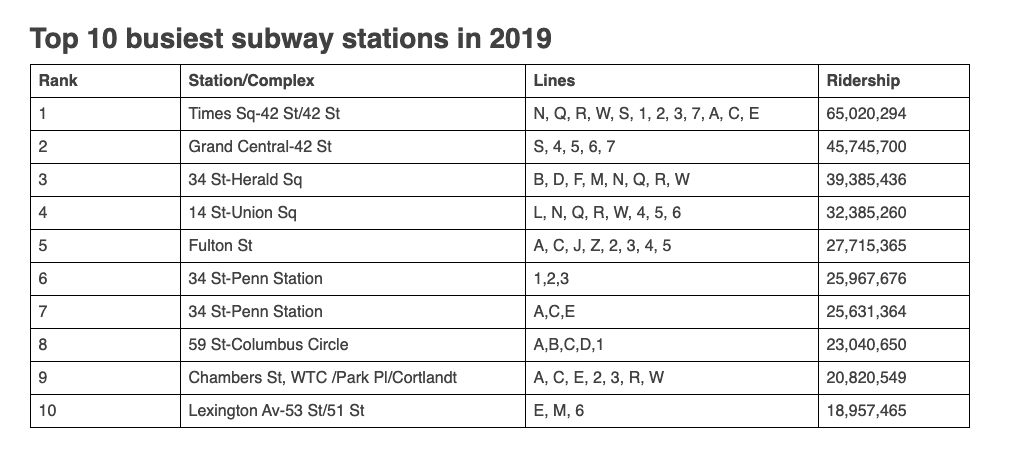